In [1]:
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
def plot_learning_curve_hyper(df, x_axis_label, y_axis_label, title, ax=None, ylim=None):
  x = []
  for ele in df.params:
    for k, v in ele.items():
      x.append(str(v))
  if ax is None:
    _, ax = plt.subplots(figsize=(14, 10))

  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.grid()
  ax.fill_between(
    x,
    (df['mean_train_score'] - df['std_train_score']).values,
    (df['mean_train_score'] + df['std_train_score']).values,
    alpha=0.1,
    color="r",
    )
  ax.fill_between(
    x,
    (df['mean_test_score'] - df['std_test_score']).values,
    (df['mean_test_score'] + df['std_test_score']).values,
    alpha=0.1,
    color="g",
    )
  ax.plot(x, df['mean_train_score'], "x-", color = 'r', label = 'Training Score')
  ax.plot(x, df['mean_test_score'], "x-", color = 'g', label = 'Cross-validation Score')
  ax.legend(loc="best")

In [3]:
def plot_learning_curve(model, X, y, X_train=None, X_val=None, y_train=None, y_val=None):

  if X_train is None: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)
  train_errors, val_errors = [], []
  train_size = np.linspace(10, len(X_train), 10).astype(int)
  for m in train_size:
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)

    train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
    val_errors.append(f1_score(y_val, y_val_predict, average= 'macro'))
  plt.grid()
  plt.plot(train_size, train_errors, 'r', label= 'Training Error')
  plt.plot(train_size, val_errors, 'b', label = 'Validation Error')
  plt.ylabel('F1 Macro Score')
  plt.xlabel('Training Example Size')
  plt.legend(loc='best')

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Wine_Classification'

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Wine_Classification


In [6]:
import pandas as pd

df = pd.read_csv('winequality-white.csv', sep=';')

In [7]:
X = df.drop('quality', axis=1)
y = df['quality']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    stratify = y, random_state=27)

In [9]:
normal_col = ['fixed acidity', 'citric acid', 'total sulfur dioxide', 'pH',
              'alcohol', 'free sulfur dioxide', 'density']
skewd_col = ['volatile acidity', 'residual sugar', 'chlorides', 
            'sulphates']

In [10]:
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

In [11]:
#Make Pipelines for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col)])

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report


clf_ada = AdaBoostClassifier(random_state=0)


clf_ada.fit(X_train, y_train)
y_pred = clf_ada.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1))
print(f'Missed Classes in Test set:\n {set(y_test) - set(y_pred)}')

              precision    recall  f1-score   support

           3       0.02      0.40      0.04         5
           4       1.00      0.00      0.00        41
           5       0.46      0.55      0.50       364
           6       0.48      0.60      0.53       550
           7       1.00      0.00      0.00       220
           8       1.00      0.00      0.00        44
           9       1.00      0.00      0.00         1

    accuracy                           0.44      1225
   macro avg       0.71      0.22      0.15      1225
weighted avg       0.60      0.44      0.39      1225

Missed Classes in Test set:
 {8, 9, 4, 7}


In [40]:
#Try Quick and Dirty Adaboost Classifier on Processed Data
from sklearn.metrics import classification_report, f1_score

clf_ada_p = AdaBoostClassifier(random_state=0)

clf_ada_p.fit(X_train_stand, y_train)

y_pred_p = clf_ada_p.predict(X_test_stand)

print(f'Classification report with naive SVM using processed data:\n {classification_report(y_pred_p, y_test, zero_division=1)}')
print(f'Missed Classes in Test set:\n {set(y_test) - set(y_pred_p)}')

Classification report with naive SVM using processed data:
               precision    recall  f1-score   support

           3       0.40      0.02      0.04        96
           4       0.00      1.00      0.00         0
           5       0.55      0.46      0.50       442
           6       0.60      0.48      0.53       687
           7       0.00      1.00      0.00         0
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0

    accuracy                           0.44      1225
   macro avg       0.22      0.71      0.15      1225
weighted avg       0.57      0.44      0.48      1225

Missed Classes in Test set:
 {8, 9, 4, 7}


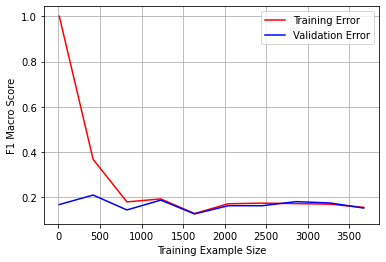

In [41]:
plot_learning_curve(clf_ada_p, X, y, X_train= X_train_stand, X_val = X_test_stand, y_train = y_train, y_val = y_test)

In [14]:
X_train_stand_df = pd.DataFrame(X_train_stand, columns=X_train.columns)
X_test_stand_df = pd.DataFrame(X_test_stand, columns=X_test.columns)

In [15]:
# Feature Selection using Anova Analysis
from sklearn.feature_selection import SelectKBest, f_classif

selection = SelectKBest(f_classif, k=6)



selection.fit(X_train_stand_df, y_train)

print(f'List of features inputed:\n {selection.feature_names_in_}\n')
print(f'List of features selected:\n {X_train_stand_df.columns[selection.get_support()]}')

X_train_selected = selection.transform(X_train_stand_df)
X_test_selected = selection.transform(X_test_stand_df)

List of features inputed:
 ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']

List of features selected:
 Index(['citric acid', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'sulphates'],
      dtype='object')


In [16]:
#Try Quick and Dirty Adaboost Classifier on Processed and Selected Data
from sklearn.metrics import classification_report

clf_ada_ps = AdaBoostClassifier(random_state=0)

clf_ada_ps.fit(X_train_selected, y_train)

y_pred_ps = clf_ada_ps.predict(X_test_selected)

print(f'Classification report with naive SVM using processed data:\n {classification_report(y_pred_ps, y_test, zero_division=1)}')
print(f'Missed Classes in Test set:\n {set(y_test) - set(y_pred_ps)}')

Classification report with naive SVM using processed data:
               precision    recall  f1-score   support

           3       0.40      0.01      0.01       283
           4       0.00      1.00      0.00         0
           5       0.26      0.42      0.32       230
           6       0.62      0.48      0.54       712
           7       0.00      1.00      0.00         0
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0

    accuracy                           0.36      1225
   macro avg       0.18      0.70      0.12      1225
weighted avg       0.50      0.36      0.38      1225

Missed Classes in Test set:
 {8, 9, 4, 7}


In [17]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__criterion': ['gini', 'entropy']}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__criterion': ['gini', 'entropy']},
             return_train_score=True, scoring='f1_macro')

In [18]:
df_base_criterion = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__criterion': 'entropy'}

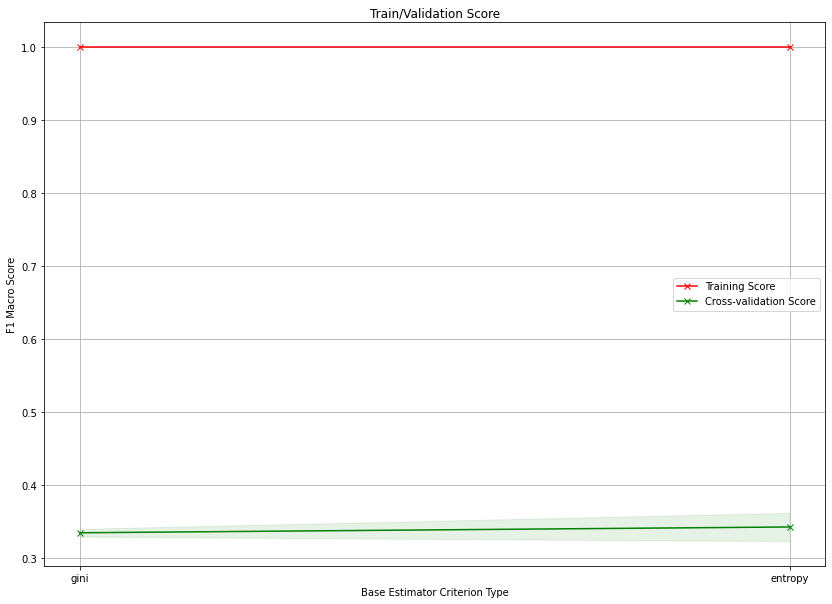

In [19]:
plot_learning_curve_hyper(df_base_criterion, 'Base Estimator Criterion Type', 
                          'F1 Macro Score', 'Train/Validation Score')

In [20]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__splitter': ['best', 'random']}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__splitter': ['best', 'random']},
             return_train_score=True, scoring='f1_macro')

In [21]:
df_base_splitter = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__splitter': 'best'}

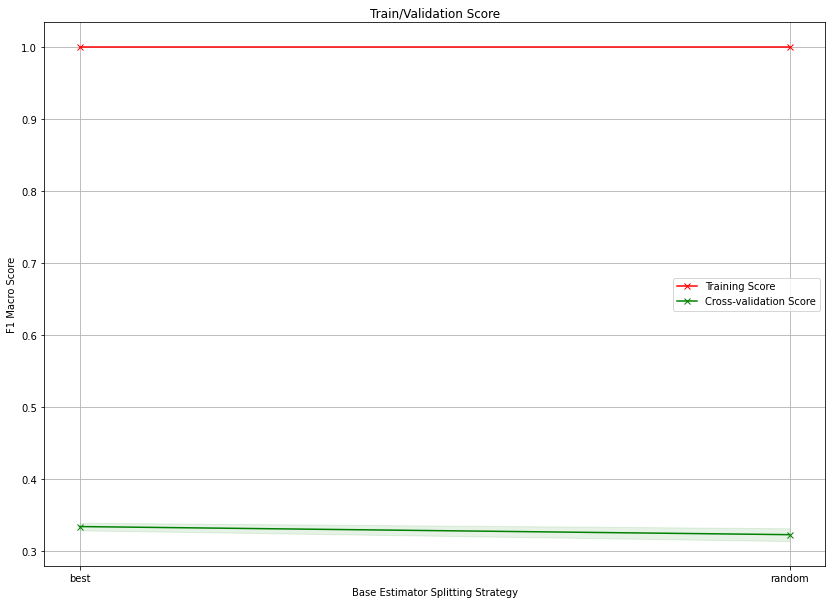

In [22]:
plot_learning_curve_hyper(df_base_splitter, 'Base Estimator Splitting Strategy', 
                          'F1 Macro Score', 'Train/Validation Score')

In [23]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__max_depth': [i for i in range(2,30,2)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                       16, 18, 20, 22, 24, 26,
                                                       28]},
             return_train_score=True, scoring='f1_macro')

In [24]:
df_base_depth = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__max_depth': 14}

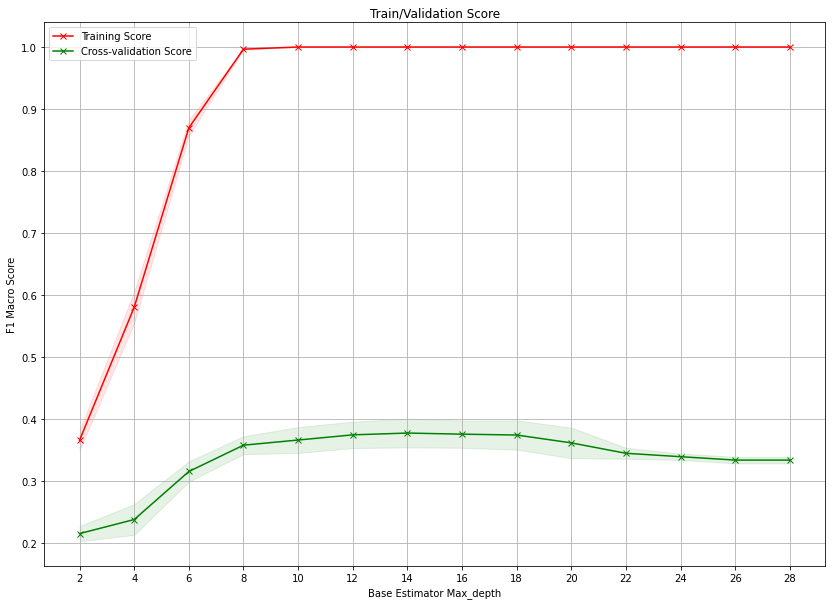

In [25]:
plot_learning_curve_hyper(df_base_depth, 'Base Estimator Max_depth', 
                          'F1 Macro Score', 'Train/Validation Score')

In [26]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__min_samples_split': [i for i in range(2,10)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__min_samples_split': [2, 3, 4, 5, 6, 7,
                                                               8, 9]},
             return_train_score=True, scoring='f1_macro')

In [27]:
df_base_min_split = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__min_samples_split': 4}

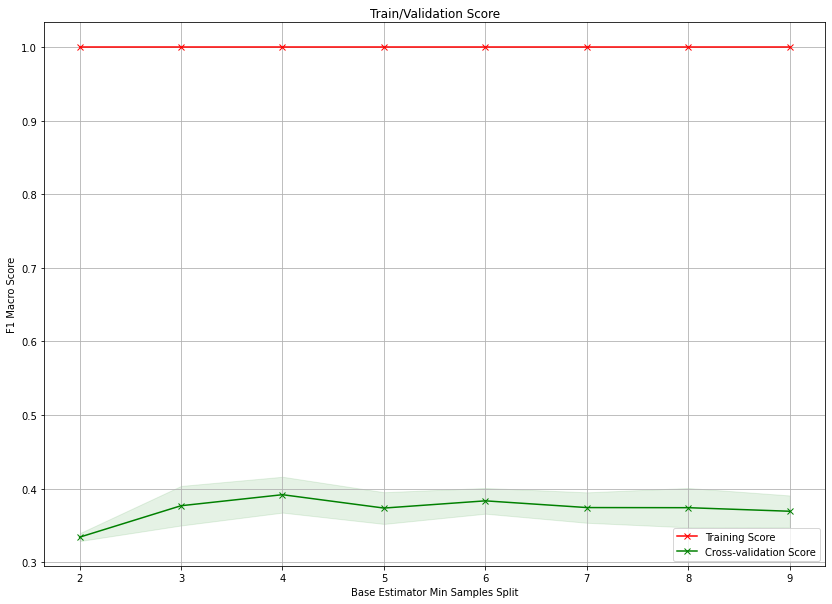

In [28]:
plot_learning_curve_hyper(df_base_min_split, 'Base Estimator Min Samples Split', 
                          'F1 Macro Score', 'Train/Validation Score')

In [29]:
#Optimizing Base Estimator Parameters

base_est = DecisionTreeClassifier(random_state=0)

param_grid = {'base_estimator__min_samples_leaf': [i for i in range(1,10)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=4)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                          random_state=0),
             param_grid={'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9]},
             return_train_score=True, scoring='f1_macro')

In [30]:
df_base_min_leaf = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'base_estimator__min_samples_leaf': 2}

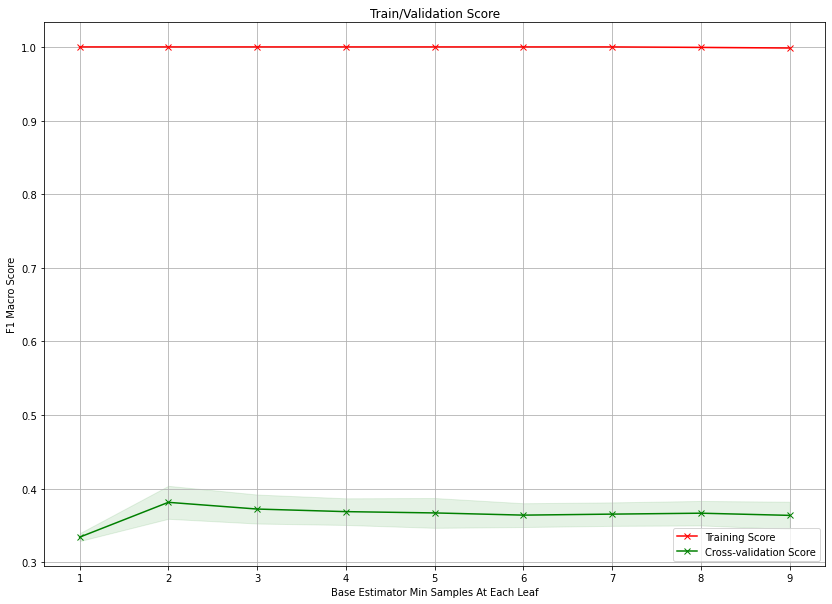

In [31]:
plot_learning_curve_hyper(df_base_min_leaf, 'Base Estimator Min Samples At Each Leaf', 
                          'F1 Macro Score', 'Train/Validation Score')

In [32]:
#Optimizing Adaboost algo parameters
#Base estimator Decision Tree with min samples split of 4 is selected for further optimization due to its higher macro accuracy 
base_est = DecisionTreeClassifier(random_state=0, min_samples_split= 4)

param_grid = {'n_estimators': [i for i in range(76, 88)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True,
                           cv=4, n_jobs= -1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=4,
                                                                                random_state=0),
                                          random_state=0),
             n_jobs=-1,
             param_grid={'n_estimators': [76, 77, 78, 79, 80, 81, 82, 83, 84,
                                          85, 86, 87]},
             return_train_score=True, scoring='f1_macro')

In [33]:
df_ada_est = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'n_estimators': 80}

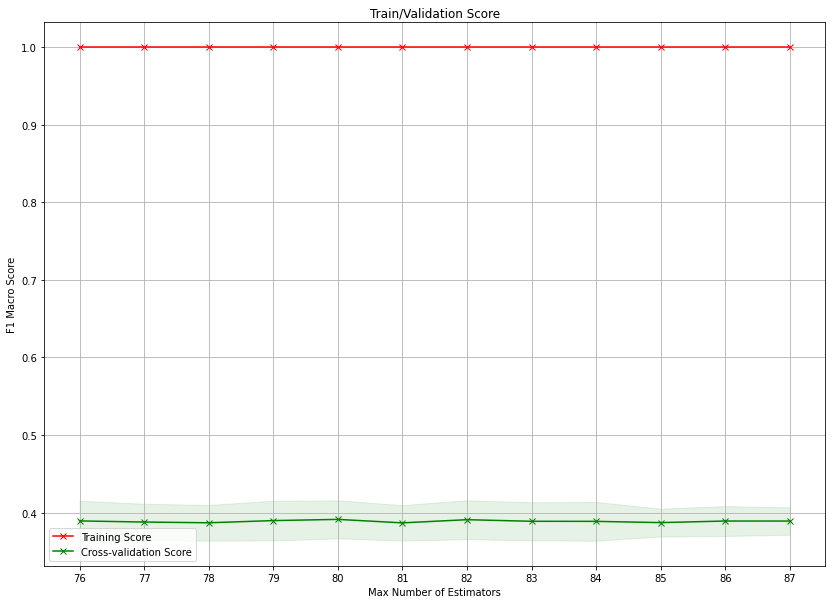

In [34]:
plot_learning_curve_hyper(df_ada_est, 'Max Number of Estimators', 
                          'F1 Macro Score', 'Train/Validation Score')

In [35]:
#Optimizing Adaboost algo parameters
import numpy as np

base_est = DecisionTreeClassifier(random_state=0, min_samples_split= 4)

param_grid = {'learning_rate': np.arange(0.5,2,0.1).round(2)}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True, cv=4, n_jobs= -1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=4,
                                                                                random_state=0),
                                          random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9])},
             return_train_score=True, scoring='f1_macro')

In [36]:
df_ada_learning_rate = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'learning_rate': 1.0}

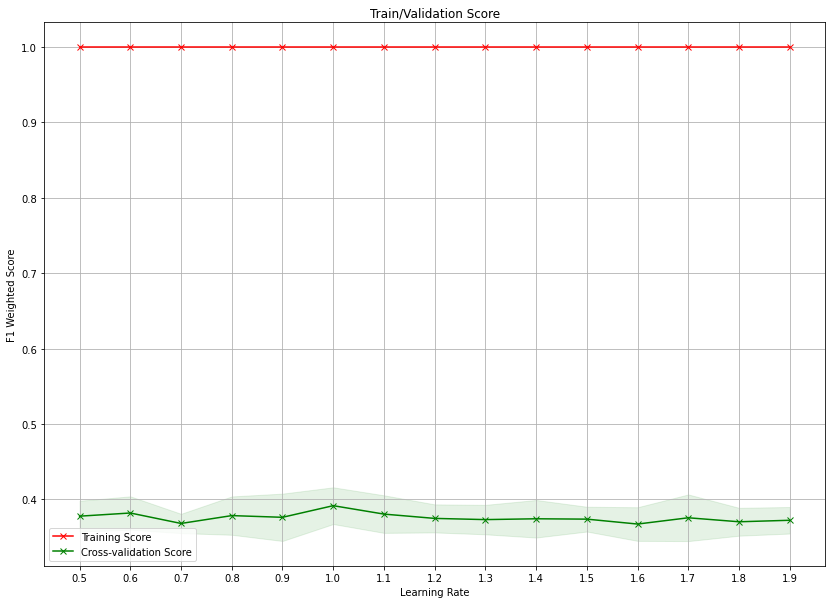

In [37]:
plot_learning_curve_hyper(df_ada_learning_rate, 'Learning Rate', 
                          'F1 Weighted Score', 'Train/Validation Score')

In [ ]:
#Optimizing Adaboost algo parameters finding the best trade off between n_estimator and learning rate
import numpy as np

base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4)

param_grid = {'learning_rate': np.arange(0.5,2,0.1).round(2),
              'n_estimators': [i for i in range(70, 100, 5)]}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True,
                           cv=4, n_jobs= -1)

grid_search.fit(X_train, y_train)

In [ ]:
df_ada_est_rate = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

In [ ]:
from sklearn.metrics import f1_score
model_n_lr = grid_search.best_estimator_
plot_learning_curve(model_n_lr, X, y)

In [ ]:
#Optimizing Adaboost algo parameters
import numpy as np

base_est = DecisionTreeClassifier(random_state=0, min_samples_split=4)

param_grid = {'algorithm': ['SAMME', 'SAMME.R']}

clf_ada = AdaBoostClassifier(base_estimator=base_est, random_state=0)

grid_search = GridSearchCV(clf_ada, param_grid= param_grid,
                           scoring = 'f1_macro', return_train_score=True,
                           cv=4, n_jobs= -1)

grid_search.fit(X_train, y_train)

In [ ]:
df_ada_algo = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

In [ ]:
plot_learning_curve_hyper(df_ada_algo, 'Adaboost algorithm', 
                          'F1 Macro Score', 'Train/Validation Score')

In [ ]:
y_pred_n_est = model_n_lr.predict(X_test)
print(f"F1 Weighted Score on Test Set: {f1_score(y_test, y_pred_n_est, average='macro'):.2f}")
print(f'\nClassification report on test set:\n\n {classification_report(y_test, y_pred_n_est, zero_division=1)}')
print(f'\nClassification report on training set:\n\n {classification_report(y_train, model_n_lr.predict(X_train), zero_division=1)}')